In [1]:
# Install libraries
!pip install geodatasets

# Import libraries
from datetime import datetime
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Download the 311 complaints about syringes
syringe_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?descriptor=Syringes&$limit=50000')
syringe_complaints.head(2)

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,64598275,2025-04-09T09:53:54.000,2025-04-09T14:08:51.000,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10002.0,99 SUFFOLK STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.718729,-73.986227,"\n, \n(40.718728547929224, -73.9862266969104)"
1,64598543,2025-04-09T09:33:09.000,2025-04-09T14:10:13.000,DSNY,Department of Sanitation,Dirty Condition,Syringes,Gutter,10002.0,124 RIDGE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.719233,-73.983041,"\n, \n(40.719233158523394, -73.98304117648323)"


In [3]:
# Examine the syringe_complaints data types
syringe_complaints.dtypes

,0
unique_key,int64
created_date,object
closed_date,object
agency,object
agency_name,object
complaint_type,object
descriptor,object
location_type,object
incident_zip,float64
incident_address,object


In [4]:
# Convert created_date from an object to a date
syringe_complaints['created_date'] = pd.to_datetime(syringe_complaints['created_date'])

In [5]:
# Extract month and year from created_date
syringe_complaints['created_month'] = syringe_complaints['created_date'].dt.month
syringe_complaints['created_year'] = syringe_complaints['created_date'].dt.year

In [6]:
# Look for missing values
syringe_complaints.isna().sum()

,0
unique_key,0
created_date,0
closed_date,5
agency,0
agency_name,0
complaint_type,0
descriptor,0
location_type,0
incident_zip,1
incident_address,1


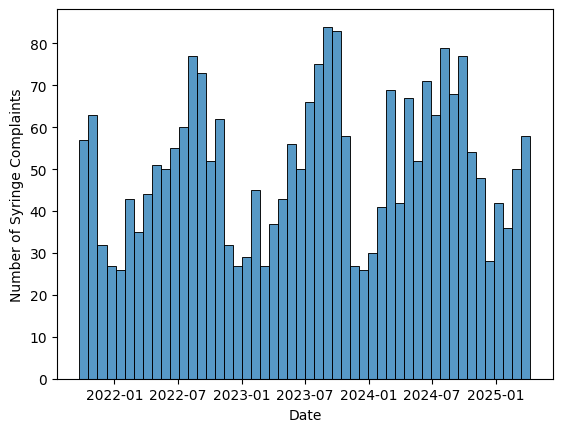

In [7]:
# Make a histogram to show the frequency of syringe complaints
ax = sns.histplot(data=syringe_complaints['created_date'], bins = 50)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Syringe Complaints')
plt.show()

Interesting finding: syringe complaints appear to peak at similar times each year!

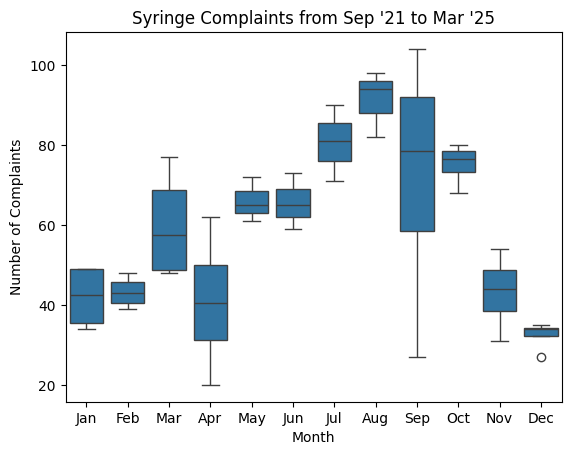

In [8]:
# Make a boxplot to show the number of syringe complaints each month
ax = sns.boxplot(data = syringe_complaints.groupby(['created_year', 'created_month'])['created_date'].agg(complaint_count = 'count').reset_index(),
                 x = 'created_month',
                 y = 'complaint_count')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Complaints')
plt.title('Syringe Complaints from Sep \'21 to Mar \'25')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

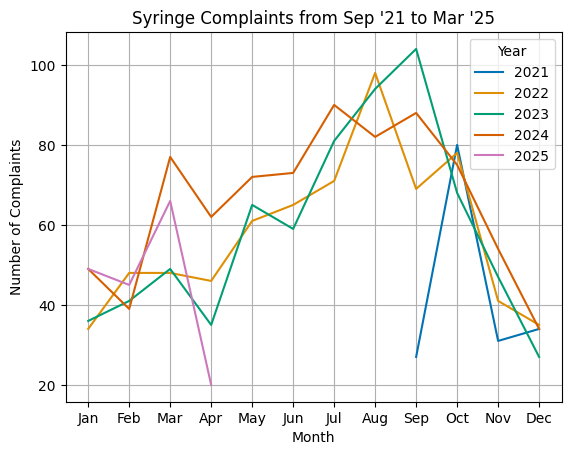

In [9]:
# Make a lineplot of the number of syringe complaints each month, with a different line pear year
ax = sns.lineplot(data = syringe_complaints.groupby(['created_year', 'created_month'])['created_date'].agg(complaint_count = 'count').reset_index(),
                  x = 'created_month',
                  y = 'complaint_count',
                  hue = 'created_year',
                  palette = 'colorblind')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.title('Syringe Complaints from Sep \'21 to Mar \'25')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()

It looks like syringe complaints were only reported in the 311 system starting in September 2021, so for the rest of my analysis I will focus on 2022-2024.

In [10]:
# Download all of the 311 complaints in 2022, 2023, and 2024
# To limit the size of the download, select only unique_key, created_date, complaint_type, descriptor, longitude, and latitude
all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022,2023,2024)%20LIMIT%2050000000')
all_311_complaints.head(2)

,unique_key,created_date,complaint_type,descriptor,longitude,latitude
0,55457657,2022-09-18T08:47:10.000,Illegal Dumping,Removal Request,-73.847427,40.790782
1,55456964,2022-09-18T12:14:11.000,Drinking,In Public,-73.912725,40.756887


In [11]:
# Drop rows that do not have latitude and longitude data
all_311_complaints = all_311_complaints.dropna(subset = ['latitude', 'longitude'], how = 'any', ignore_index = True)

In [13]:
# Make all_311_complaints a GeoDataFrame
all_311_complaints = gpd.GeoDataFrame(all_311_complaints, geometry = gpd.points_from_xy(all_311_complaints.longitude, all_311_complaints.latitude), crs = 'EPSG:4326').to_crs(2263)

In [14]:
# Download the city council districts shape file
!wget https://www.nyc.gov/assets/districting/downloads/misc/20221006-Final-Plan-Districts.zip -O ccd.zip
!unzip ccd.zip

--2025-04-11 02:01:08--  https://www.nyc.gov/assets/districting/downloads/misc/20221006-Final-Plan-Districts.zip
Resolving www.nyc.gov (www.nyc.gov)... 23.60.17.170, 2600:1407:3c00:1a88::1500, 2600:1407:3c00:1a98::1500
Connecting to www.nyc.gov (www.nyc.gov)|23.60.17.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128976 (126K) [application/zip]
Saving to: ‘ccd.zip’

ccd.zip             100%[===================>] 125.95K  --.-KB/s    in 0.03s   

2025-04-11 02:01:08 (3.85 MB/s) - ‘ccd.zip’ saved [128976/128976]

Archive:  ccd.zip
  inflating: Districts 2022-10-06.dbf  
  inflating: Districts 2022-10-06.key  
  inflating: Districts 2022-10-06.prj  
  inflating: Districts 2022-10-06.shp  
  inflating: Districts 2022-10-06.shx  


In [15]:
# Load city council districts shape file
ccd_shape = gpd.read_file('/content/Districts 2022-10-06.shp')
ccd_shape = ccd_shape.to_crs(2263)

In [16]:
# Perform a spatial join to match each 311 complaint with its city council district
all_311_complaints = all_311_complaints.sjoin(ccd_shape[['DISTRICT', 'geometry']], how="left")

In [17]:
# Convert created_date from an object to a date
all_311_complaints['created_date'] = pd.to_datetime(all_311_complaints['created_date'])

# Extract month and year from created_date
all_311_complaints['created_month'] = all_311_complaints['created_date'].dt.month
all_311_complaints['created_year'] = all_311_complaints['created_date'].dt.year

In [18]:
# Rename DISTRICT to district
all_311_complaints = all_311_complaints.rename(columns = {'DISTRICT': 'district'})

Do 311 complaints generally follow the same seasonal trend as syringe complaints?

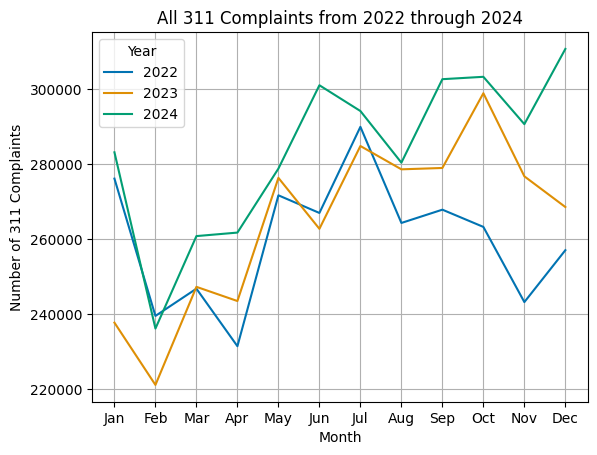

In [19]:
# Make a lineplot of the number of 311 complaints each month, with a different line per year
ax = sns.lineplot(data = all_311_complaints.groupby(['created_year', 'created_month'])['created_date'].agg(complaint_count = 'count').reset_index(),
                  x = 'created_month',
                  y = 'complaint_count',
                  hue = 'created_year',
                  palette = 'colorblind')
plt.xlabel('Month')
plt.ylabel('Number of 311 Complaints')
plt.title('All 311 Complaints from 2022 through 2024')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()

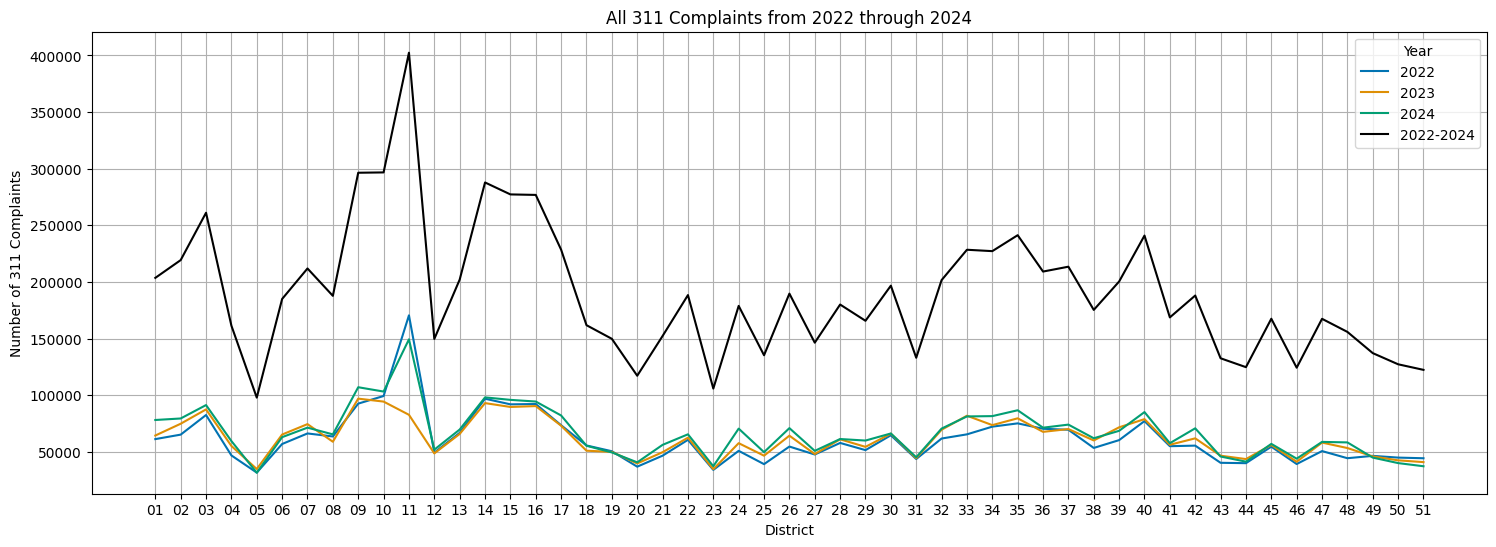

In [20]:
# How do the amounts of 311 complaints among city council districts vary from year to year?
plt.figure(figsize=(18, 6))
ax = sns.lineplot(data = all_311_complaints.groupby(['district', 'created_year'])['created_date'].agg(complaint_count = 'count').reset_index(),
                  x = 'district',
                  y = 'complaint_count',
                  hue = 'created_year',
                  palette = 'colorblind')

# Also plot the 311 complaints from all three years
ax = sns.lineplot(data = all_311_complaints.groupby(['district'])['created_date'].agg(complaint_count = 'count').reset_index(),
                  x = 'district',
                  y = 'complaint_count',
                  color = 'black',
                  label = '2022-2024')

plt.xlabel('District')
plt.ylabel('Number of 311 Complaints')
plt.title('All 311 Complaints from 2022 through 2024')
plt.legend(title='Year')
plt.grid(True)
plt.show()

Since the trend in 311 complaints among the different city council districts is very similar from year to year, I will group the complaints by city council district only.

In [21]:
# Group by city council district and count the total complaints and syringe complaints
complaints_by_ccd = all_311_complaints.groupby('district').agg(all_complaints=('unique_key', 'count'), syringe_complaints=('descriptor', lambda x: (x == 'Syringes').sum()))

# Next, calculate the normalized syringe complaints
complaints_by_ccd['normalized_syringe_complaints'] = complaints_by_ccd['syringe_complaints'] / complaints_by_ccd['all_complaints']

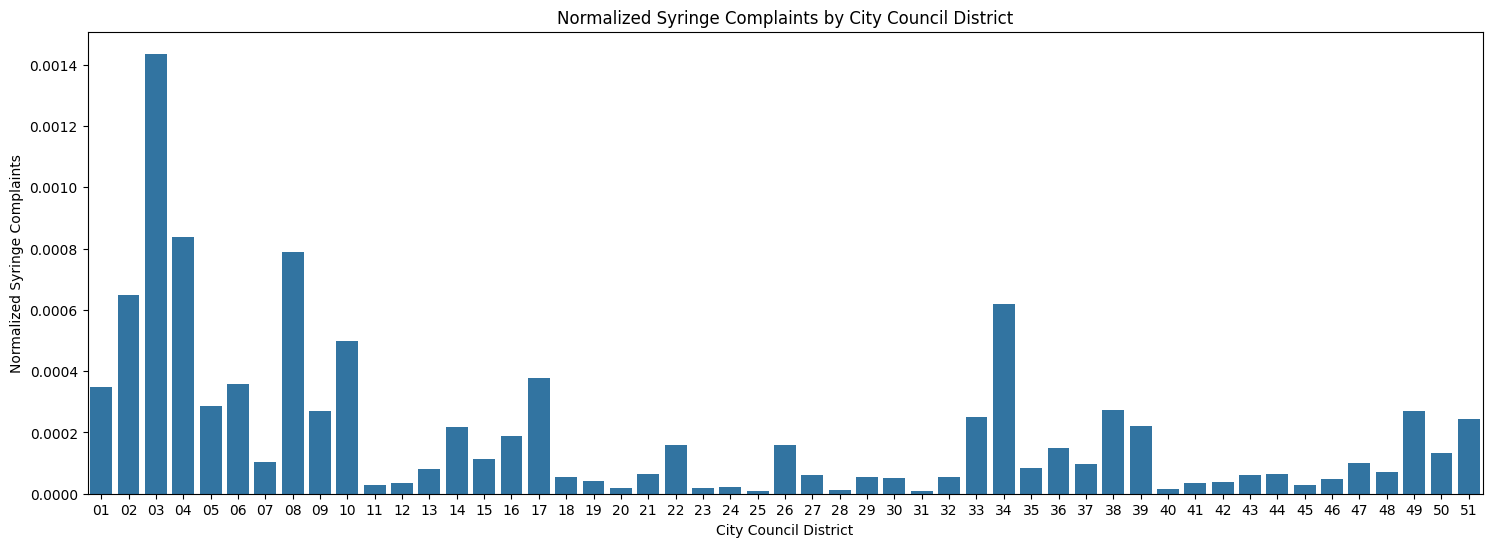

In [22]:
# Plot the normalized syringe complaints by city council district
plt.figure(figsize=(18, 6))
sns.barplot(data = complaints_by_ccd['normalized_syringe_complaints'])
plt.xlabel('City Council District')
plt.ylabel('Normalized Syringe Complaints')
plt.title('Normalized Syringe Complaints by City Council District')
plt.show()

Notes below, to be cleaned up later

In [23]:
# Save all_311_complaints as a pickle file
import pickle
all_311_complaints.to_pickle('all_311_complaints.pkl')

In [ ]:
# Download the sharps dropoff site data
dropoff_sites = pd.read_csv('https://data.cityofnewyork.us/resource/edk2-vkjh.csv')
dropoff_sites.head(2)

,borough,ntaname,site_type,sitename,zipcode,phonenum,days_hours,address,borocd,notes,...,councildist,senate_district,_congress_district,assembly_district,police_precints,bbl,bin,latitude,longitude,point
0,Bronx,Norwood,SYRINGE/SHARPS Drop-off,North Central Bronx Hospital,10467,718-918-5000,24/7,"3424 Kossuth Ave, Bronx, NY 10467",207,Lobby,...,11,33,15,81,52,2.033270e+09,2017787.0,40.880432,-73.881204,POINT (-73.881205418129 40.8804402931774)
1,Queens,Flushing-Willets Point,SYRINGE/SHARPS Drop-off,Union Plaza Care Center,11354,718-670-0765,10am-2pm,"33-23 Union St. Flushing, NY 11354",407,Lobby,...,20,16,6,40,109,4.049810e+09,4112550.0,40.767323,-73.826924,POINT (-73.8269253950036 40.7673312732314)


In [ ]:
# Examine the data types
dropoff_sites.dtypes

,0
borough,object
ntaname,object
site_type,object
sitename,object
zipcode,int64
phonenum,object
days_hours,object
address,object
borocd,int64
notes,object


In [ ]:
# Look for missing values
dropoff_sites.isna().sum()

,0
borough,0
ntaname,0
site_type,0
sitename,0
zipcode,0
phonenum,153
days_hours,153
address,0
borocd,0
notes,153


In [ ]:
# Look at the values in the 'days_hours' column
dropoff_sites['days_hours'].value_counts()

,count
days_hours,
24/7,26
Monday-Friday 9am-5pm,19
9am-5pm,14
Monday-Friday 8am-4pm,7
10am-4pm,4
...,...
Monday-Thursday 10am-3pm,1
Monday-Sunday 11am-1pm,1
"Monday, Tuesday, Friday 9am-5pm; Wednesday 10AM-5PM; Thursday 9AM-7PM",1


I would like to parse these values into something more quantitative, like hours open per month. However, I will come back to that later.

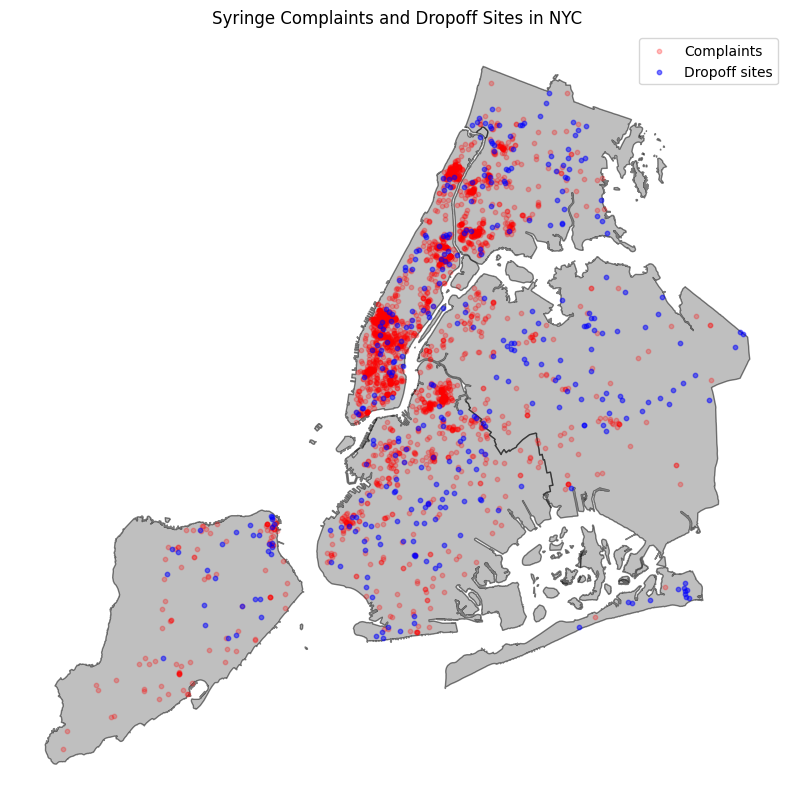

In [ ]:
# Load map of NYC for plotting
# CRS = 2263 (NAD83 / New York Long Island (ftUS))
nyc = gpd.read_file(geodatasets.get_path('nybb'))

# Make GeoDataFrames from the syringe_complaints and dropoff_sites DataFrames into
# Not projecting
syringe_complaints_geo = gpd.GeoDataFrame(syringe_complaints, geometry = gpd.points_from_xy(syringe_complaints.longitude, syringe_complaints.latitude), crs = 'EPSG:4326')
dropoff_sites_geo = gpd.GeoDataFrame(dropoff_sites, geometry = gpd.points_from_xy(dropoff_sites.longitude, dropoff_sites.latitude), crs = 'EPSG:4326')

# Change CRS to 2263, projecting coord
syringe_complaints_geo = syringe_complaints_geo.to_crs(2263)
dropoff_sites_geo = dropoff_sites_geo.to_crs(2263)

# Plot the map of NYC
ax = nyc.plot(figsize = (10, 10), alpha = 0.5, color = 'gray', edgecolor = 'k')

# Plot the syringe complaints and dropoff locations
syringe_complaints_geo.plot(ax = ax, markersize = 10, alpha = 0.25, color = 'red')
dropoff_sites_geo.plot(ax = ax, markersize = 10, alpha = 0.5, color = 'blue')

# Format the plot
ax.set_axis_off()
ax.legend(['Complaints', 'Dropoff sites'])
plt.title('Syringe Complaints and Dropoff Sites in NYC')
plt.show()

In [ ]:
# Load city council districts shape file
ccd = gpd.read_file('/Districts 2022-10-06.shp').to_crs(epsg=2263)

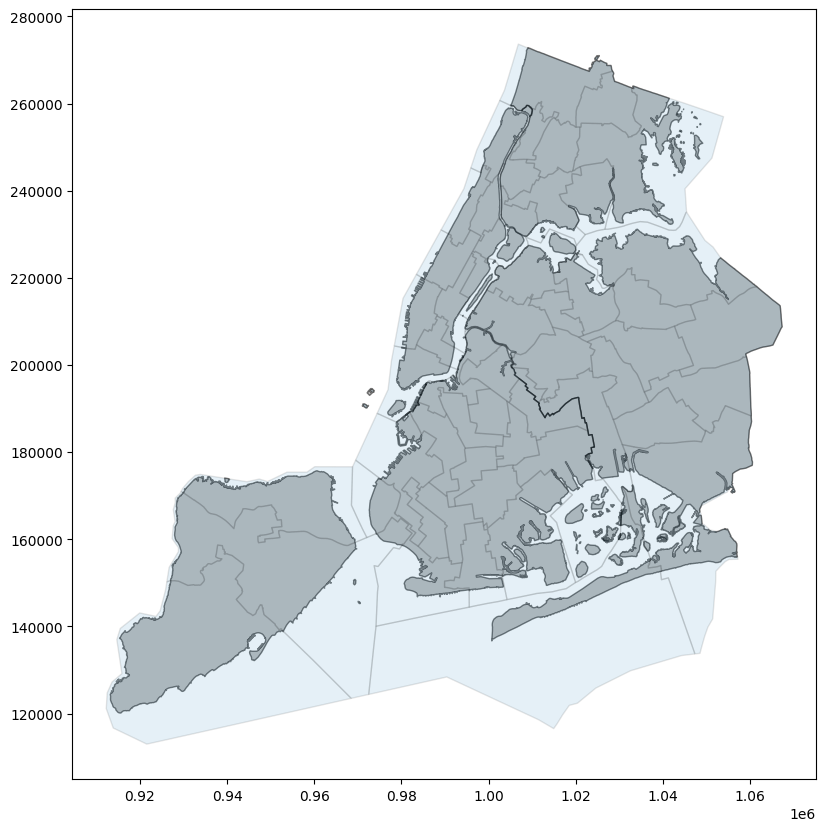

In [ ]:
# Try plotting this?
ax = nyc.plot(figsize = (10, 10), alpha = 0.5, color = 'gray', edgecolor = 'k')
ccd.plot(ax = ax, edgecolor = 'k', alpha = 0.1)
plt.show()

# Looking at other 311 complaints and their distribution in NYC

In [ ]:
all_complaints_10k = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$limit=10000')

In [ ]:
all_complaints_10k.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,64493126,2025-03-29T01:49:52.000,NaN,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11102.0,24-34 28 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.772895,-73.917798,"\n, \n(40.772895123556644, -73.91779840809791)"
1,64489698,2025-03-29T01:49:48.000,NaN,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10003.0,45 2 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.725333,-73.990057,"\n, \n(40.72533283110231, -73.99005683996256)"
2,64490846,2025-03-29T01:49:22.000,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,11237.0,24 WYCKOFF AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.706366,-73.922544,"\n, \n(40.70636560745412, -73.92254403726173)"
3,64490971,2025-03-29T01:49:16.000,NaN,NYPD,New York City Police Department,Noise - Vehicle,Engine Idling,Street/Sidewalk,10301.0,137 BENZIGER AVENUE,...,SUV,NaN,NaN,NaN,NaN,NaN,NaN,40.639762,-74.083223,"\n, \n(40.639762323003076, -74.08322303866501)"
4,64493342,2025-03-29T01:48:38.000,NaN,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10467.0,316 EAST 211 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.880094,-73.873414,"\n, \n(40.880093772136696, -73.87341414442069)"


Extracting 'nybb_16a/nybb.shp' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'


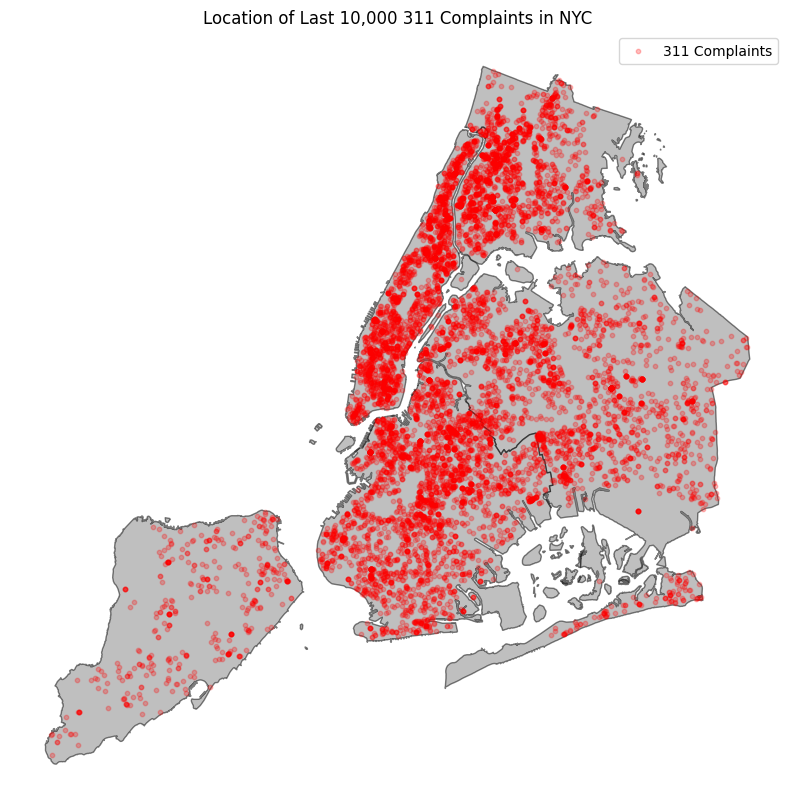

In [ ]:
# Load map of NYC for plotting
# CRS = 2263 (NAD83 / New York Long Island (ftUS))
nyc = gpd.read_file(geodatasets.get_path('nybb'))

# Make GeoDataFrames from the syringe_complaints and dropoff_sites DataFrames into
# Not projecting
all_complaints_10k_geo = gpd.GeoDataFrame(all_complaints_10k, geometry = gpd.points_from_xy(all_complaints_10k.longitude, all_complaints_10k.latitude), crs = 'EPSG:4326')

# Change CRS to 2263, projecting coord
all_complaints_10k_geo = all_complaints_10k_geo.to_crs(2263)

# Plot the map of NYC
ax = nyc.plot(figsize = (10, 10), alpha = 0.5, color = 'gray', edgecolor = 'k')

# Plot the syringe complaints and dropoff locations
all_complaints_10k_geo.plot(ax = ax, markersize = 10, alpha = 0.25, color = 'red')

# Format the plot
ax.set_axis_off()
ax.legend(['311 Complaints', 'Dropoff sites'])
plt.title('Location of Last 10,000 311 Complaints in NYC')
plt.show()

# Testing code below, work in progress!

## Using an LLM to parse the dropoff site opening hours

In [ ]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('google_api_key')

from google import genai
from google.genai import types
from IPython.display import HTML, Markdown, display

In [ ]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

client = genai.Client(api_key=GOOGLE_API_KEY)

In [ ]:
dropoff_sites['days_hours']

,days_hours
0,24/7
1,10am-2pm
2,9am-5pm
3,24/7
4,First and Last Friday of every month 2pm-4pm
...,...
341,Monday-Wednesday 9
342,Call for mobbile unit locations and hours
343,NaN
344,NaN


In [ ]:
from pydantic import BaseModel

class Response(BaseModel):
  logical: str
  hours_per_month: int

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=f'''The site hours are {dropoff_sites.loc[i, 'days_hours']}. Does this make logical sense, Yes or No?
    How many hours in a 28-day month is the site open?''',
    config={
        'response_mime_type': 'application/json',
        'response_schema': list[Response],
    },
)
# Use the response as a JSON string.
print(response.parsed[0].logical, response.parsed[0].hours_per_month)

No 0


In [ ]:
# Test Gemini with first 10 rows in dropoff_sites dataframe
from pydantic import BaseModel

class Response(BaseModel):
  logical: str
  hours_per_month: int

for i in range(10):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      contents=f'''The site hours are {dropoff_sites.loc[i, 'days_hours']}. Does this make logical sense, Yes or No?
      How many hours in a 28-day month is the site open?''',
      config={
          'response_mime_type': 'application/json',
          'response_schema': list[Response],
      },
  )
  # Use the response as a JSON string.
  print(response.parsed[0].logical, response.parsed[0].hours_per_month)

Yes 672
Yes 112
Yes 224
Yes 672
Yes 4
No 0
No 0
Yes 196
Yes 168
No 0


In [ ]:
# Calculate the opening hours per month for each site
from pydantic import BaseModel

class Response(BaseModel):
  logical: str
  hours_per_month: int

for i in range(len(dropoff_sites)):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      contents=f'''The site hours are {dropoff_sites.loc[i, 'days_hours']}. Does this make logical sense, Yes or No?
      How many hours in a 28-day month is the site open?''',
      config={
          'response_mime_type': 'application/json',
          'response_schema': list[Response],
      },
  )
  # Save the calculated hours
  if response.parsed[0].logical == 'Yes':
    dropoff_sites.loc[i, 'hours_per_month'] = response.parsed[0].hours_per_month
  else:
    dropoff_sites.loc[i, 'hours_per_month'] = np.nan

  # Track progress
  if i % 50 == 0:
    print(f'Progress: {i} rows')

Progress: 0 rows
Progress: 50 rows
Progress: 100 rows
Progress: 150 rows
Progress: 200 rows
Progress: 250 rows
Progress: 300 rows


In [ ]:
dropoff_sites['hours_per_month'][0:10]

,hours_per_month
0,672
1,112
2,224
3,672
4,4
5,NaN
6,NaN
7,196
8,168
9,NaN
